In [1]:
import numpy as np

In [2]:
from scipy.stats import norm
import matplotlib.pyplot as plt

In [3]:
def plot_distribution(ax, pdfs, title=''): 
    x = np.linspace(0., 10., 200)
    ymax = 0    
    for index, pdf in enumerate(pdfs):
        y = norm.pdf(x, pdf.mean, np.sqrt(pdf.var))

        p = ax.plot(x, y, lw = 2)
        c = p[0].get_markeredgecolor()    
        ax.fill_between(x, y, 0, color=c, alpha=0.2 )    
        ax.autoscale(tight=True)
        ax.vlines(pdf.mean, 0, y.max(), colors=c, linestyles="--", lw=2)    

        ymax = max(ymax, y[1:].max()*1.05)
    ax.set_ylim([0, ymax])

def plot_regret(ax, regret, title=''): 
    ax.plot(regret)

def plot(regret, mab):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    plot_regret(axs[0], regret)
    plot_distribution(axs[1], mab)

In [4]:
class Arm:
    def __init__(self, mean, var):
        self.mean = mean
        self.var = var

    def sample(self):
        return np.random.normal(self.mean, np.sqrt(self.var))

    def name(self):
        return 'N(' + str(self.mean) + ',' + str(self.var) + ')'

# Thompson Sampling

In this exercise we will run thompson sampling for 2-armed bandit with gaussian distribution.
For simplicity assume we know variance of distribution of arms and only mean is unknown
for prior assume gaussian distribution.

## 1.
if variance was unknown what prior distribtion would be suitable?

> A suitable prior distribution for the variance would be the inverse gamma distribution.

> The inverse gamma distribution is a conjugate prior for the Gaussian distribution with unknown variance. This means that if we assume that the variance follows an inverse gamma distribution, the posterior distribution of the variance given the observed data will also be an inverse gamma distribution.

$$f(x; \alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} x^{-\alpha -1} e^{-\frac{\beta}{x}}$$

## 2.
Implement Thompson Sampling algorithm. For comparison also implement ϵ-Greedy and UCB algorithms

In [20]:
class ThompsonSampling:
    def __init__(self, var_list, **kwargs):
        """
        variance of arms are known to policy
        """
        self.arm_vars = var_list
        self.prior_means = [10] * len(var_list)
        self.prior_vars = [1] * len(var_list) 

    def select_arm(self, *args):
        # ==================================== Your Code (Begin) ==================================
        # select arm based on estimate of prior distribution
        # return index of selected arm
        theta_list = np.random.normal(self.prior_means, np.sqrt(self.prior_vars))
        return np.argmax(theta_list)
        # ==================================== Your Code (End) ====================================

    def update(self, idx, reward):
        # ==================================== Your Code (Begin) ==================================
        # update prior based on reward
        posterior_var = 1 / ((1/self.arm_vars[idx]) + (1/self.prior_vars[idx]))
        posterior_mean = posterior_var * (
            self.prior_means[idx]/self.prior_vars[idx] + 
            reward/self.arm_vars[idx])
        self.prior_means[idx] = posterior_mean
        self.prior_vars[idx] = posterior_var
        # ==================================== Your Code (End) ====================================

In [81]:
class UCB:    
    def __init__(self, n_bandits, c_level):
        """
        c_level: coefficient of uncertainty
        """
        self.c_level = c_level
        self.values = [0] * n_bandits
        self.counts = [0] * n_bandits

    def select_arm(self, t):
        """
        t: step time
        """
        # ==================================== Your Code (Begin) ==================================
        # select arm based on UCB
        # return index of selected arm
        ucb_values = [val + self.c_level * np.sqrt(np.log(t) / cnt) 
                      if cnt > 0 else float('inf') 
                      for val, cnt in zip(self.values, self.counts)]
        return np.argmax(ucb_values)
        # ==================================== Your Code (End) ====================================

    def update(self, idx, reward):
        # ==================================== Your Code (Begin) ==================================
        # update based on reward
        self.counts[idx] += 1
        self.values[idx] += (1/self.counts[idx]) * (reward - self.values[idx])
        # ==================================== Your Code (End) ====================================

In [13]:
class eGreedy:
    def __init__(self, n_bandits, epsilon):
        """
        epsilon must be given
        """
        self.epsilon = epsilon
        self.values = [0] * n_bandits
        self.counts = [0] * n_bandits
    
    def select_arm(self, *args):
        # ==================================== Your Code (Begin) ==================================
        # select arm based on e-Greedy
        # return index of selected arm
        if np.random.random() > self.epsilon:
            return np.argmax(self.values)
        else:
            return np.random.choice(len(self.values))
        # ==================================== Your Code (End) ====================================

    def update(self, idx, reward):
        # ==================================== Your Code (Begin) ==================================
        # update based on reward
        self.counts[idx] += 1
        self.values[idx] += (1/self.counts[idx]) * (reward - self.values[idx])
        # ==================================== Your Code (End) ====================================

## 3
run simulation for arms described as cells below and describe the differences of regret with different variance in arms distributions

rum_sim1 must return cumulitive regret formulated as 
$$
R(T)=\sum_{i=1}^2 N_i(T) \Delta_i
$$

where $N_i(T)$ is number of times arm $i$ was selected until step $T$, $\Delta_i=\mu^*-\mu_i$, $\mu^*$ is largest mean in arms distribtions and $\mu_i$ is mean of distribution of arm $i$

to get average regret we rum simulation 50 times.

In [14]:
def run_sim1(policy, mab, step_num=100):
    """
    run simulation of multi-armed bandit
    mab: list of arms
    """
    best_mean = np.max([b.mean for b in mab])
    regret = []
    counts = [0] * len(mab)
    for t in range(step_num):          
        # ==================================== Your Code (Begin) ==================================
        # run policy algorithm and return cumulative regret
        arm_idx = policy.select_arm(t)
        reward = mab[arm_idx].sample()
        policy.update(arm_idx, reward)
        counts[arm_idx] += 1
        r_t = sum([cnt * (best_mean - arm.mean)
                   for cnt, arm in zip(counts, mab)])
        regret.append(r_t)
        # ==================================== Your Code (End) ====================================
    return regret

### 3.1
Assume Multi-Armed Bandit variables are as follows.

In [60]:
mab = [Arm(6, 0.5), Arm(4, 0.5)]

#### Thompson Sampling
run and describe the result.

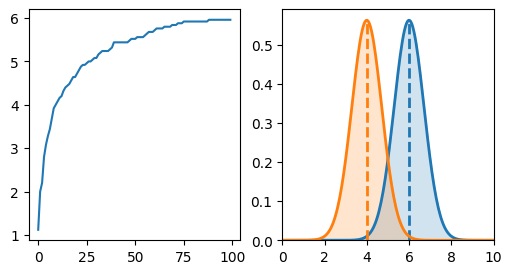

In [61]:
regret = [run_sim1(ThompsonSampling([b.var for b in mab]), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

> As you can see, It seems like a log function. The cumulative regret plot of a multi-arm bandit algorithm with two Gaussian arms can look like a logarithmic function because of the nature of the algorithm and the arms.

> As the algorithm continues to pull the arm with the higher meanreward, the regret rate decreases at a decreasing rate, resulting in a logarithmic shape. This is because the probability of selecting the suboptimal arm decreases over time, and the algorithm becomes increasingly confident about the arm with the higher mean reward. As a result, the algorithm explores less and less, resulting in diminishing returns in terms of reducing regret.

> The logarithmic shape of the cumulative regret plot for a two-armed bandit algorithm with Gaussian arms illustrates the exploration-exploitation tradeoff and how the algorithm learns over time to balance exploration and exploitation to maximize its total reward.

#### ϵ-Greedy
run for different values of ϵ and compare results.

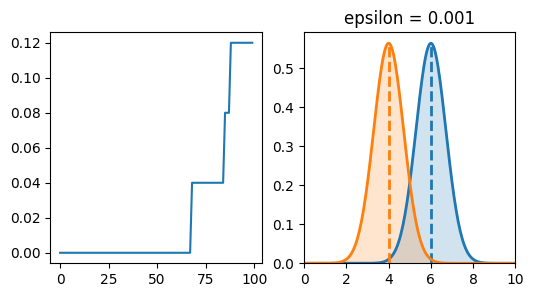

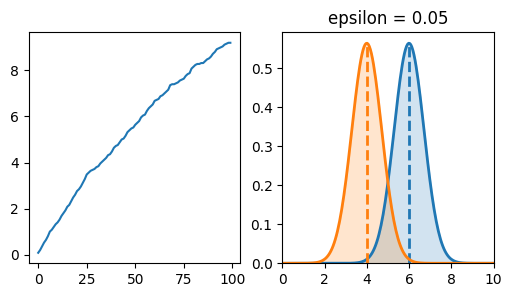

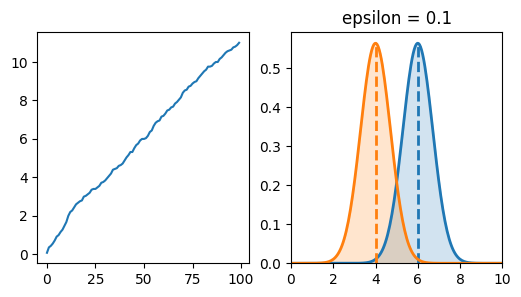

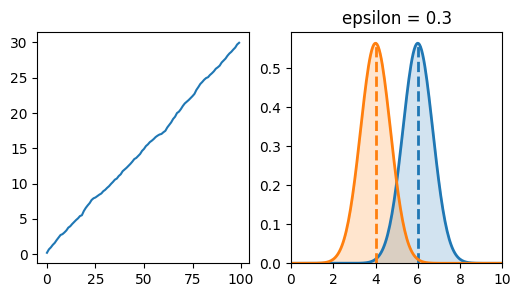

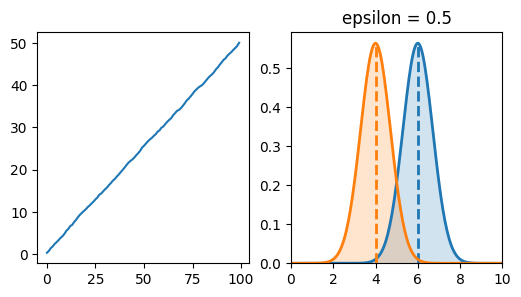

In [62]:
epsilons = [0.001, 0.05, 0.1, 0.3, 0.5]

for epsilon in epsilons:
    regret = [run_sim1(eGreedy(2, epsilon=epsilon), mab) for _ in range(50)]
    plot(np.mean(regret, axis=0), mab)
    plt.title(f'epsilon = {epsilon}')

> When the value of epsilon increases in epsilon-greedy multi-arm bandit, the cumulative regret can become higher because the algorithm is more likely to select a suboptimal arm in each round.

> In epsilon-greedy multi-arm bandit, the algorithm selects the arm with the highest empirical mean reward with probability 1-epsilon, and it selects a random arm with probability epsilon. When epsilon is small, the algorithm is more likely to select the arm with the highest empirical mean reward, which is more likely to be the optimal arm. However, when epsilon is large, the algorithm is more likely to select a random arm, which can be a suboptimal arm.



#### UCB
run for different values of confidence level and compare results.


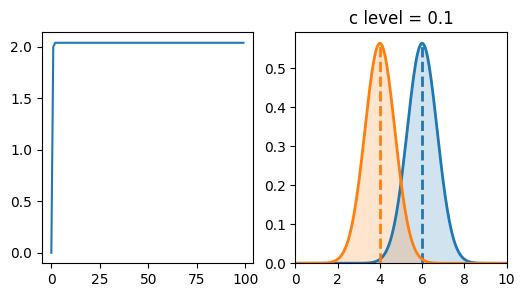

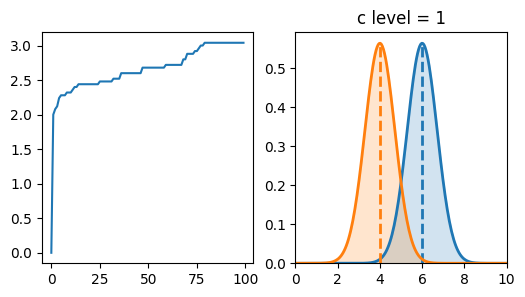

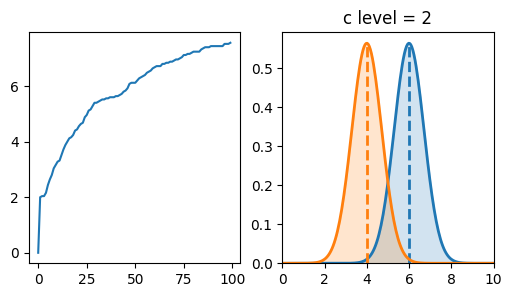

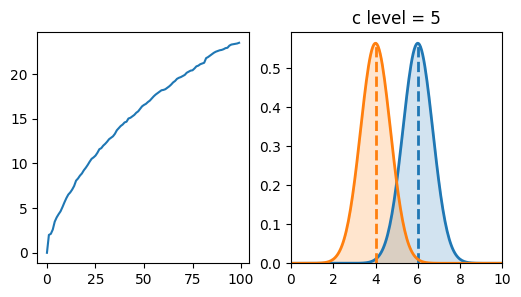

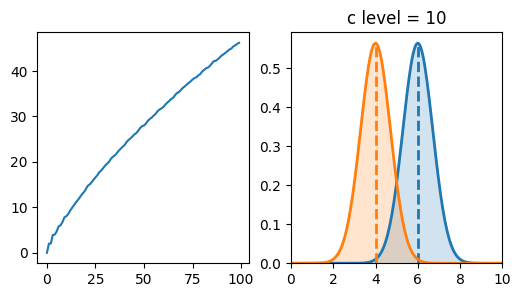

In [63]:
c_levels = [0.1, 1, 2, 5, 10]

for c_level in c_levels:
    regret = [run_sim1(UCB(2, c_level=c_level), mab) for _ in range(50)]
    plot(np.mean(regret, axis=0), mab)
    plt.title(f'c level = {c_level}')

> When the value of `c` increases in epsilon-greedy multi-arm bandit, the cumulative regret can become higher because because the algorithm becomes more exploratory and may select suboptimal arms more frequently.

> Finding the appropriate value of "c" requires balancing exploration and exploitation to maximize the total reward and minimize the cumulative regret. A higher value of "c" can lead to more exploration and potentially higher rewards, but at the cost of more suboptimal selectionsdue to excessive exploration. Conversely, a lower value of "c" can lead to less exploration but with a lower risk of suboptimal selections, which can reduce the cumulative regret.

### 3.2
Assume Multi-Armed Bandit variables are as follows.

In [70]:
mmab = [Arm(6, 10), Arm(4, 10)]

#### Thompson Sampling
run and compare results.

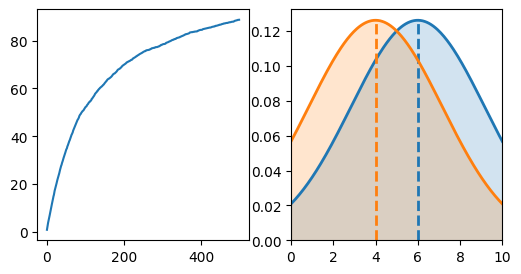

In [71]:
regret = [run_sim1(ThompsonSampling([b.var for b in mmab]), mmab, step_num=500) for _ in range(50)]
plot(np.mean(regret, axis=0), mmab)

> The cumulative regret is higher with compare to the previous part. This is because of the fact that in this part variances of arms are higher and it's more difficult to find the mean.

#### ϵ-Greedy
run for different values of ϵ and compare results.

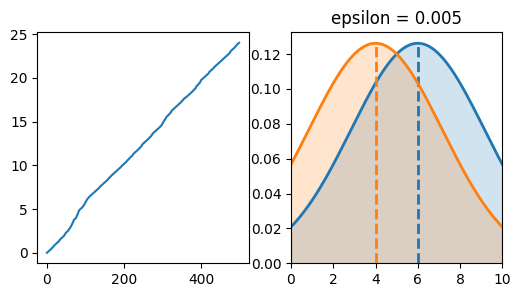

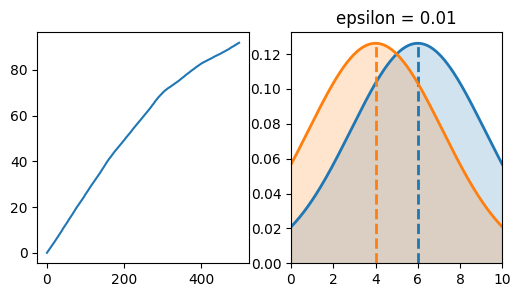

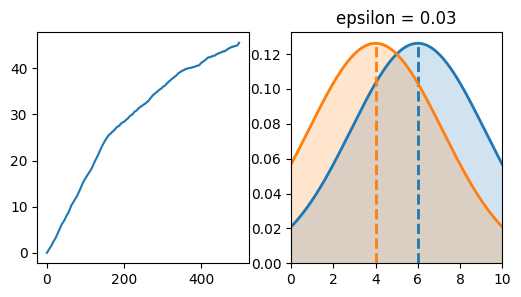

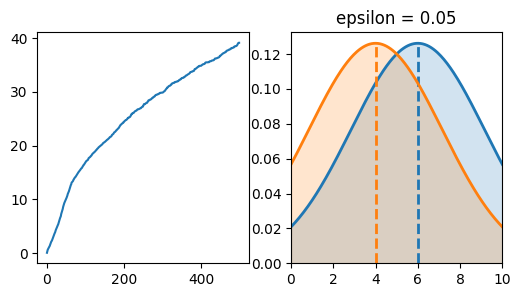

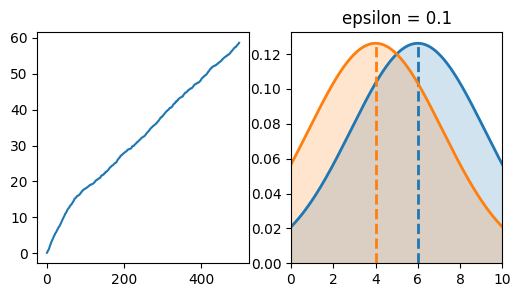

In [75]:
epsilons = [0.005, 0.01, 0.03, 0.05, 0.1]

for epsilon in epsilons:
    regret = [run_sim1(eGreedy(2, epsilon=epsilon), mmab, step_num=500) for _ in range(50)]
    plot(np.mean(regret, axis=0), mmab)
    plt.title(f'epsilon = {epsilon}')

> Like previous part, when the epsilon increases, the cumulative regret also increases. (same reason)

> When the arms' variance is large, the smaller epsilons has not the same affect as in the previous part.



#### UCB
run for different values of confidence level and compare results.

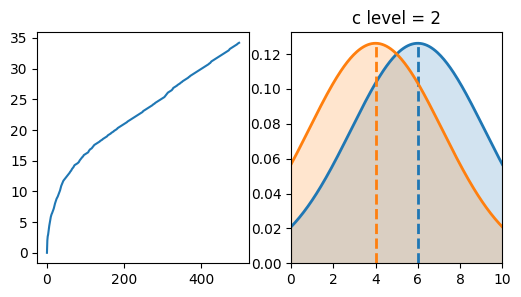

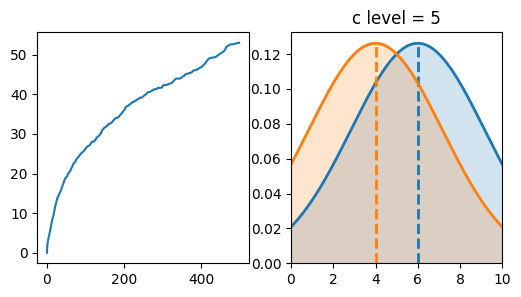

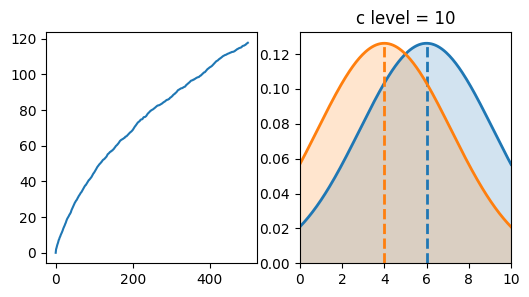

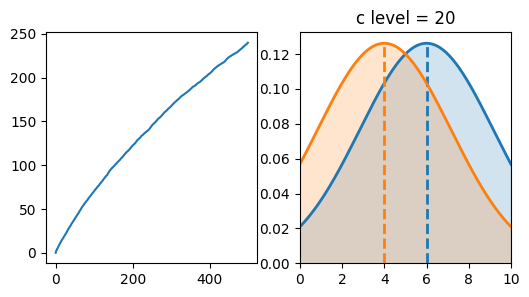

In [82]:
c_levels = [2, 5, 10, 20]

for c_level in c_levels:
    regret = [run_sim1(UCB(2, c_level=c_level), mmab, step_num=500) for _ in range(50)]
    plot(np.mean(regret, axis=0), mmab)
    plt.title(f'c level = {c_level}')

> Like previous part, when the `c` increases, the cumulative regret also increases. (same reason)

> When the arms' variance is large, the smaller `c` has not the same affect as in the previous part.

## 4
simulation below assumes a non-stationary multi-armed bandit. specifically in this simulation mean value of distribution of first arm changes in step 100. describe the result of thompson sampling.

In [40]:
def run_sim2(ts, mab, step_num=200, change_step=100):
    init_mean = mab[0].mean
    best_mean = np.max([b.mean for b in mab])
    regret = []
    step_regret_cum = 0
    for i in range(step_num):
        if i == change_step:
            mab[0].mean = 2
            best_mean = np.max([b.mean for b in mab])
        # ==================================== Your Code (Begin) ==================================
        # run tompson sampling algorithm and return cumulative regret
        arm_idx = ts.select_arm()
        reward = mab[arm_idx].sample()
        ts.update(arm_idx, reward)
        step_regret_cum += best_mean - mab[arm_idx].mean
        regret.append(step_regret_cum)
        # ==================================== Your Code (End) ====================================
    mab[0].mean = init_mean
    return regret

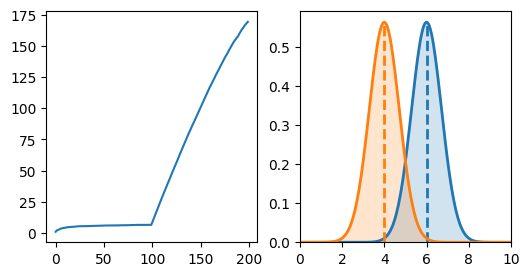

In [41]:
mab = [Arm(6, 0.5), Arm(4, 0.5)]
regret = [run_sim2(ThompsonSampling([b.var for b in mab]), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

> In n this simulation, the mean value of the distribution of the first arm changes at step 100. The result of the cumulative regret of Thompson Sampling algorithm increases suddenly after the insertion of this change point because the algorithm is not able to adapt to the sudden change in the reward distribution of the first arm.

> To adapt to sudden changes in the reward distribution, Thompson Sampling algorithm can use a forgetting factor that discounts the importance of older rewards and gives more weight to recent rewards. 

### 4.1
change thompson sampling algorithm to improve results in non-stationary MAB.

In [46]:
class NewThompsonSampling:
    def __init__(self, var_list, buffer_size=30, **kwargs):
        self.var_list = var_list
        self.buffer_size = buffer_size
        self.buffer = [[]] * len(var_list)
        self.mean_list = [10] * len(var_list)

    def select_arm(self, *args):
        # ==================================== Your Code (Begin) ==================================
        # select arm based on estimate of prior distribution
        # return index of selected arm
        arm_idx = np.argmax(np.random.normal(
            self.mean_list, np.sqrt(self.var_list)))
        return arm_idx
        # ==================================== Your Code (End) ====================================

    def update(self, idx, reward):
        # ==================================== Your Code (Begin) ==================================
        # update prior based on reward
        self.buffer[idx].append(reward)
        self.buffer[idx] = self.buffer[idx][-self.buffer_size:]
        self.mean_list[idx] = np.mean(self.buffer[idx])
        # ==================================== Your Code (End) ====================================

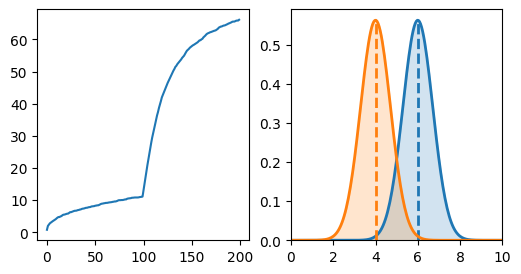

In [47]:
mab = [Arm(6, 0.5), Arm(4, 0.5)]
regret = [run_sim2(NewThompsonSampling([b.var for b in mab]), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

> This can help the algorithm adapt more quickly to sudden changes in the reward distribution. As we can see, the cumulative result of this algorithm is better due to less cumulative regret.

> The sudden increase in the cumulative regret of Thompson Sampling algorithm after the insertion of a change point in a non-stationary multi-armed bandit problem can be attributed to the algorithm's inability to adapt quickly to sudden changes in the reward distribution. To mitigate this issue, the algorithm can use a forgetting factor technique to update its probability distribution more quickly and accurately.